In [1]:
import json
from collections import Counter, defaultdict, deque
import gc

import numpy as np
import pandas as pd
import glob
import time
from tqdm import tqdm

from sklearn import model_selection, metrics
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sn

import lightgbm as lgb
from scipy.stats import skew

import feather
import pickle
import h5py

from concurrent import futures
#import riiideducation

In [2]:
question = pd.read_csv("/home/pocket/input/questions.csv")
question.head(2)

,question_id,bundle_id,correct_answer,part,tags
0,0,0,0,1,51 131 162 38
1,1,1,1,1,131 36 81


<AxesSubplot:>

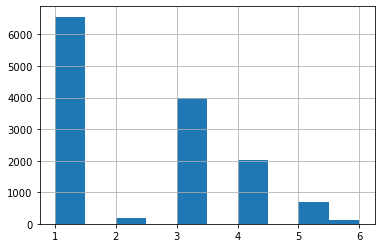

In [3]:
question["tags"].astype(str).apply(lambda x: len(x.split())).hist()

In [4]:
lecture = pd.read_csv("/home/pocket/input/lectures.csv")
lecture.head(2)

,lecture_id,tag,part,type_of
0,89,159,5,concept
1,100,70,1,concept


In [5]:
lecture = lecture.set_index("lecture_id")
lectures_dict = lecture.to_dict("index")

In [76]:
train = pd.read_feather("./train_sorted_full2.feather")

In [7]:
#train["prior_question_had_explanation"].fillna(False, inplace=True)

In [8]:
#train["prior_question_had_explanation"] = train["prior_question_had_explanation"].astype(int)

In [9]:
# use_col = [
#     'row_id', 'timestamp', 'user_id', 'content_id', 'content_type_id',
#     'task_container_id', 'user_answer', 'answered_correctly',
#     'prior_question_elapsed_time', 'prior_question_had_explanation',
# ]
# train[use_col].to_feather("./train_sorted_full2.feather")

In [10]:
print(train.columns)

# no lectures for now
#train = train[train["answered_correctly"] != -1]

Index(['row_id', 'timestamp', 'user_id', 'content_id', 'content_type_id',
       'task_container_id', 'user_answer', 'answered_correctly',
       'prior_question_elapsed_time', 'prior_question_had_explanation'],
      dtype='object')


In [11]:
train.head(2)

,row_id,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation
0,32933156,0,705741139,128,0,0,0,1,NaN,0
1,32933157,20666,705741139,7860,0,1,0,1,16000.0,0


In [12]:
class PocketCounter():
    def __init__(self):
        self.cnt = Counter()
        self.sum = Counter()
    
    def update(self, key, sum_val):
        self.cnt[key] += 1
        self.sum[key] += sum_val
        
    def get_mean(self, key):
        return (self.sum[key] / self.cnt[key]) if self.cnt[key] != 0 else np.nan

class PocketRoller():
    def __init__(self, roll50=False):
        self.roll = defaultdict(self.get_deq20)
            
    def update(self, key, val):
        self.roll[key].append(val)
        
    def get_deq20(self):
        return deque(maxlen=20)
    
    def get_mean(self, key):
        return sum(self.roll[key]) / len(self.roll[key]) if len(self.roll[key]) != 0 else np.nan
    

class PocketTimestamp():
    def __init__(self):
        self.prev_ts = {}
        self.prev_td = 0
        self.td = 0
    
    def update(self, key, ts):
        td = self.prev_ts.get(key, np.nan) - ts
        if td < 0 or np.isnan(td):
            self.td = td
            self.prev_td = td
        else:
            self.td = self.prev_td
        self.prev_ts[key] = ts
        
    def update_only_ts(self, key, ts):
        self.prev_ts[key] = ts
        
    def get_simple_td(self, key, ts):
        return self.prev_ts.get(key, np.nan) - ts

    
class PocketTSRoller():
    def __init__(self):
        self.roll = defaultdict(self.get_deq)
    
    def update(self, key, val):
        if len(self.roll[key]) == 0:
            self.roll[key].append(val)
        
        if val - self.roll[key][-1] != 0:
            self.roll[key].append(val)
        else:
            pass
    
    def get_prev_t(self, key, t):
        if len(self.roll[key]) < t:
            return np.nan
        else:
            return self.roll[key][-t]
        
    def get_deq(self):
        return deque(maxlen=10)
            
    
class PocketElo():
    def __init__(self):
        self.u_theta = {}
        self.u_cnt = {}
        self.left_asymptote = 0.25
        
    def get_theta(self, uid):
        if uid not in self.u_theta.keys():
            return np.nan
        else:
            return self.u_theta[uid]
        
    def init_user(self, uid):
        if uid not in self.u_theta.keys():
            self.u_theta[uid] = 0
            self.u_cnt[uid] = 0
    
    def update(self, uid, ac, beta):
        self.init_user(uid)
        
        theta, cnt = self.u_theta[uid], self.u_cnt[uid]
        self.u_theta[uid] = self.get_new_theta(ac, beta, theta, cnt)
        self.u_cnt[uid] += 1
    
    def get_new_theta(self, ac, beta, theta, cnt):
        return theta + self.learning_rate_theta(cnt) * (ac - self.ac_prob(theta, beta))
    
    def learning_rate_theta(self, cnt):
        return max(0.3 / (1 + 0.01 * cnt), 0.04)
    
    def ac_prob(self, theta, beta):
        return self.left_asymptote + (1 - self.left_asymptote) * self.sigmoid(theta - beta)

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

In [96]:
class PocketFeatureFactory():
    def __init__(self, is_train, contents_dict):
        self.u_ac = PocketCounter()
        self.uc_ac = PocketCounter()
        self.u_qm = PocketCounter()
        self.u_ac_roll = PocketRoller()
        self.u_ts = PocketTimestamp()
        self.uc_ts = PocketTimestamp()
        self.u_ok_qm = PocketCounter()
        self.u_ng_qm = PocketCounter()
        self.up_ac = PocketCounter()
        self.ulr_ac = PocketCounter()
        self.uca_ac = PocketCounter()
        self.ut_ac = PocketCounter()
        self.ul_ts = PocketTimestamp()
        self.u_ts_wl = PocketTimestamp()
        self.u_ts_roll = PocketTSRoller()
        self.u_elo = PocketElo()
        self.u_rate = PocketCounter()
        
        self.u_ng_ts = PocketTimestamp()
        
        self.u_first_b = {}
        
        self.contents_dict = contents_dict
        self.is_train = is_train
        
    def get_row_tuple(self, row):
        ts, uid, cid, tcid = row[1], row[2], row[3], row[5]
        if self.is_train:
            et = row[8]
            pqhe = row[9]
        else:
            et = row[6]
            pqhe = row[7]
            
        return (ts, uid, cid, tcid, et, pqhe)
        
    def unpack_row(self, row):
        (ts, uid, cid, tcid, et, pqhe) = self.get_row_tuple(row)
        
        contents = self.contents_dict[cid]
        qm = contents["q_ac_mean"]
        bid = contents["bundle_id"]
        part = contents["part"]
        ca = contents["correct_answer"]
        lr = part < 5
        tags = contents["tags"].split()
        
        ucid = (uid, cid)
        utcid = (uid, tcid)
        ubid = (uid, bid)
        upid = (uid, part)
        ulr = (uid, lr)
        uca = (uid, ca)
        return (ts, uid, cid, tcid, et, pqhe, qm, tags, ucid, utcid, ubid, upid, ulr, uca)
    
    def do_lecture(self, row):
        ts, uid, cid = row[1], row[2], row[3]
        self.ul_ts.update_only_ts(uid, ts)
        self.u_ts_wl.update_only_ts(uid, ts)
        self.u_ts_roll.update(uid, ts)
    
    def update_ac_values(self, prev_rows, prev_acs, prev_uas):
        for i, row in enumerate(prev_rows):
            self.update_ac_value(row, prev_acs[i], prev_uas[i])
    
    def update_ac_value(self, row, prev_ac, prev_ua):
        ts, uid, cid, tcid, et, pqhe, qm, tags, ucid, utcid, ubid, upid, ulr, uca = self.unpack_row(row)
        contents = self.contents_dict[cid]
        
        self.u_ac.update(uid, prev_ac)
        self.uc_ac.update(ucid, prev_ac)
        self.up_ac.update(upid, prev_ac)
        self.ulr_ac.update(ulr, prev_ac)
        self.uca_ac.update(uca, prev_ac)
        self.u_ac_roll.update(uid, prev_ac)

        for tag in tags:
            ut = (uid, tag)
            self.ut_ac.update(ut, prev_ac)

        if prev_ac > 0.5:
            self.u_ok_qm.update(uid, qm)
            self.u_rate.update(uid, contents["q_ok_uac_mean"])
        else:
            self.u_ng_qm.update(uid, qm)
            self.u_rate.update(uid, contents["q_ng_uac_mean"])
            self.u_ng_ts.update_only_ts(uid, ts)
        
        beta = contents["elo_beta"]
        self.u_elo.update(uid, prev_ac, beta)

    def make_row(self, row, data_list):
        ts, uid, cid, tcid, et, pqhe, qm, tags, ucid, utcid, ubid, upid, ulr, uca = self.unpack_row(row)

        output = {}
        if self.is_train:
            output["ac"] = row[7]
        output["et"] = et
        
        contents = self.contents_dict[cid]
        content_col = [
            "q_ac_mean", "q_ac_cnt", "q_et_mean", "q_et_cnt", "q_et_std", "b_ac_mean", "b_ac_cnt",
            "part", "correct_answer",
            "q_ok_uac_mean", "q_ok_uac_std", "q_ng_uac_mean", "q_ng_uac_std",
            "elo_beta",
            "pqhe_mean"
        ]
        nn_col = [f"nn_svd{i}" for i in range(20)]
        content_col += nn_col
        
        for c in content_col:
            output[c] = contents[c]
            
        self.u_ts.update(uid, ts)
        self.uc_ts.update(ucid, ts)
        self.u_ts_wl.update(uid, ts)
        output["u_td"] = self.u_ts.td
        output["uc_td"] = self.uc_ts.td
        output["u_td_wl"] = self.u_ts_wl.td
        output["ul_td"] = self.ul_ts.get_simple_td(uid, ts)

        self.u_qm.update(uid, qm)
        output["u_cnt"] = self.u_qm.cnt[uid]
        output["u_ac_cnt"] = self.u_ac.cnt[uid]
        output["u_ac_mean"] = self.u_ac.get_mean(uid)
        output["uc_ac_cnt"] = self.uc_ac.cnt[ucid]
        output["uc_ac_mean"] = self.uc_ac.get_mean(ucid)
        output["uca_ac_mean"] = self.uca_ac.get_mean(uca)
        output["u_qm_mean"] = self.u_qm.get_mean(uid)
        output["up_ac_cnt"] = self.up_ac.cnt[upid]
        output["up_ac_mean"] = self.up_ac.get_mean(upid)
        output["ulr_ac_mean"] = self.ulr_ac.get_mean(ulr)
        output["u_ok_qm_mean"] = self.u_ok_qm.get_mean(uid)
        output["u_ng_qm_mean"] = self.u_ng_qm.get_mean(uid)
        output["u_ac_mean20"] = self.u_ac_roll.get_mean(uid)
        
        output["u_rate"] = self.u_rate.get_mean(uid)
        
        output["u_elo_theta"] = self.u_elo.get_theta(uid)
        
        if len(self.u_ac_roll.roll[uid]) < 1:
            output["uac_prev1"] = np.nan
        else:
            output["uac_prev1"]= self.u_ac_roll.roll[uid][-1]
        if len(self.u_ac_roll.roll[uid]) < 2:
            output["uac_prev2"] = np.nan
        else:
            output["uac_prev2"]= self.u_ac_roll.roll[uid][-2]
        
        up1 = self.u_ts_roll.get_prev_t(uid, 1)
        up2 = self.u_ts_roll.get_prev_t(uid, 2)
        up3 = self.u_ts_roll.get_prev_t(uid, 3)
        up4 = self.u_ts_roll.get_prev_t(uid, 4)
        up5 = self.u_ts_roll.get_prev_t(uid, 5)
        up6 = self.u_ts_roll.get_prev_t(uid, 6)
        up7 = self.u_ts_roll.get_prev_t(uid, 7)
        up8 = self.u_ts_roll.get_prev_t(uid, 8)
        up9 = self.u_ts_roll.get_prev_t(uid, 9)
        up10 = self.u_ts_roll.get_prev_t(uid, 10)
        output["u_td_tp1"] = ts - up1
        output["u_td_p1p2"] = up1 - up2
        output["u_td_p2p3"] = up2 - up3
        output["u_td_p3p4"] = up3 - up4
        output["u_td_p4p5"] = up4 - up5
        output["u_td_p5p6"] = up5 - up6
        output["u_td_p6p7"] = up6 - up7
        output["u_td_p7p8"] = up7 - up8
        output["u_td_p8p9"] = up8 - up9
        output["u_td_p9p10"] = up9 - up10
        self.u_ts_roll.update(uid, ts)
        
        #temp_b_cnt = row[11]
        #output["u_td_final"] = output["u_td_wl"] / temp_b_cnt
        #output["ub_td_final"] = output["ub_td"] / temp_b_cnt
        
        ut_sum = 0
        ut_cnt = 0
        ut_mean = []
        for tag in tags:
            ut = (uid, tag)
            ut_sum += self.ut_ac.sum[ut]
            ut_cnt += self.ut_ac.cnt[ut]
            if self.ut_ac.cnt[ut] != 0:
                ut_mean.append(self.ut_ac.get_mean(ut))
        output["ut_ac_mean"] = (ut_sum / ut_cnt) if ut_cnt != 0 else np.nan
        output["ut_ac_mean2"] = sum(ut_mean) / len(ut_mean) if len(ut_mean) != 0 else np.nan
        
        output["u_ng_ts"] = self.u_ng_ts.get_simple_td(uid, ts)
        
        uid, bid = ubid
        if uid not in self.u_first_b.keys():
            self.u_first_b[uid] = bid
        output["u_first_b"] = self.u_first_b[uid]
        

        data_list.append(output)
        return data_list


In [97]:
class PocketFFUtil():
    def __init__(self):
        pass
    
    def merge(self, ff1, ff2):
        counters = [
            "u_ac", "uc_ac", "u_qm", "u_ok_qm", "u_ng_qm",
            "up_ac", "ulr_ac", "uca_ac", "ut_ac",
            "u_rate", "u_nncl_ac", "ucl_ac"
        ]
        for counter in counters:
            c1 = getattr(ff1, counter)
            c2 = getattr(ff2, counter)
            c1.cnt.update(c2.cnt)
            c1.sum.update(c2.sum)
        
        timestamps = [
            "u_ts", "uc_ts", "ul_ts", "u_ts_wl"
        ]
        for timestamp in timestamps:
            ts1 = getattr(ff1, timestamp)
            ts2 = getattr(ff2, timestamp)
            ts1.prev_ts.update(ts2.prev_ts)
        
        rolls = ["u_ac_roll", "u_ts_roll"]
        for r in rolls:
            r1 =  getattr(ff1, r)
            r2 =  getattr(ff2, r)
            r1.roll.update(r2.roll)
            
        rates = ["u_elo"]
        for r in rates:
            r1 = getattr(ff1, r)
            r2 = getattr(ff2, r)
            r1.u_theta.update(r2.u_theta)
            r1.u_cnt.update(r2.u_cnt)
        
        return ff1
        
    def to_file(self, ff, suffix):
        uid_set, uc_dict, ut_dict = self.make_ins_dict(ff)
        
        prefix = "./temp_files"
        day = "1223"
        
        with h5py.File(f"{prefix}/uc_dict_{day}_{suffix}.hdf5", "w") as f:   
            for (uid, l) in tqdm(uc_dict.items()):
                f.create_dataset(str(uid), data=l)
                
        with h5py.File(f"{prefix}/ut_dict_{day}_{suffix}.hdf5", "w") as f:   
            for (uid, l) in tqdm(ut_dict.items()):
                f.create_dataset(str(uid), data=l)
                
#         with open(f"./uid_set_1213_{suffix}.pkl", "wb") as handle:
#             pickle.dump(uid_set, handle, pickle.HIGHEST_PROTOCOL)
        
        ff = self.del_filed_attributes(ff)
        with open(f"{prefix}/ff_{day}_{suffix}.pkl", "wb") as handle:
            pickle.dump(ff, handle, pickle.HIGHEST_PROTOCOL)
            
    def make_ins_dict(self, ff):
        uid_set = set()
        uc_dict, ut_dict = {}, {}
        #print(len(ff.ub_ac), len(ff.ub_ts), len(ff.uc_ac), len(ff.uc_ts))
        
        for k, ts in tqdm(ff.uc_ts.prev_ts.items()):
            (uid, cid) = k
            l = uc_dict.get(uid, [])
            ac_sum, ac_cnt = ff.uc_ac.sum.get(k, np.nan), ff.uc_ac.cnt.get(k, np.nan)
            new_data = [cid, ts, ac_sum, ac_cnt]
            l.append(new_data)
            uc_dict[uid] = l
            #uid_set.add(uid)
        for k, ts in tqdm(ff.ut_ac.sum.items()):
            (uid, tag) = k
            l = ut_dict.get(uid, [])
            ac_sum, ac_cnt = ff.ut_ac.sum.get(k, np.nan), ff.ut_ac.cnt.get(k, np.nan)
            new_data = [int(tag), ac_sum, ac_cnt]
            l.append(new_data)
            ut_dict[uid] = l
            #uid_set.add(uid)
        return uid_set, uc_dict, ut_dict
    
    def del_filed_attributes(self, ff):
        ff.uc_ac = PocketCounter()
        ff.uc_ts = PocketTimestamp()
        ff.ut_ac = PocketCounter()
        return ff
        

In [98]:
# content_clusters = pd.read_csv("./content_clusters.csv")

In [99]:
# content_clusters.head()

In [100]:
# content_train = train[train["answered_correctly"] != -1].copy()
# content_train["temp_uac"] = content_train.groupby("user_id")["answered_correctly"].transform("mean")
# # content_train["td"] = content_train.groupby("user_id")["timestamp"].diff()
# # content_train["td"] = content_train["timestamp"] - content_train.groupby("user_id")["timestamp"].shift()
# # content_train["td"] = content_train.groupby(["user_id", "task_container_id"])["td"].transform("max")
# # content_train["one"] = 1
# # content_train["temp_ucnt"] = content_train.groupby("user_id")["one"].cumsum()
# # content_train["temp_log_ucnt"] = np.log1p(content_train["temp_ucnt"])

# q_col = ["question_id", "bundle_id"]
# content_train = pd.merge(
#     content_train, question[q_col], left_on="content_id", right_on="question_id", how="left"
# )

# # contents features
# # there are no new contents in the test, so we use part of the train as the pseudo-training set
# temp = content_train.groupby("content_id")["answered_correctly"].agg(["mean", "count"])
# temp.columns = ["q_ac_mean", "q_ac_cnt"]
# temp2 = content_train.groupby("content_id")["prior_question_elapsed_time"].agg(["mean", "count", "std"])
# temp2.columns = ["q_et_mean", "q_et_cnt", "q_et_std"]
# # temp3 = content_train.groupby("content_id")["td"].agg(["mean", "std", "min", "max", "skew"])
# # temp3.columns = ["q_td_mean", "q_td_std", "q_td_min", "q_td_max", "q_td_skew"]
# temp4 = content_train.groupby("bundle_id")["answered_correctly"].agg(["mean", "count"])
# temp4.columns = ["b_ac_mean", "b_ac_cnt"]

# temp6 = content_train[content_train["answered_correctly"]==1]
# temp6 = temp6.groupby("content_id")["temp_uac"].agg(["mean", "std"])
# temp6.columns = ["q_ok_uac_mean", "q_ok_uac_std"]

# temp7 = content_train[content_train["answered_correctly"]==0]
# temp7 = temp7.groupby("content_id")["temp_uac"].agg(["mean", "std"])
# temp7.columns = ["q_ng_uac_mean", "q_ng_uac_std"]

# # temp8 = content_train.groupby("content_id")["temp_ucnt"].agg(["mean", "std", "skew"])
# # temp8.columns = ["q_ucnt_mean", "q_ucnt_std", "q_ucnt_skew"]
# # temp9 = content_train.groupby("content_id")["temp_log_ucnt"].agg(["mean", "std", "skew"])
# # temp9.columns = ["q_lucnt_mean", "q_lucnt_std", "q_lucnt_skew"]
# # temp10 = content_train[content_train["temp_ucnt"]>10]
# # temp10 = temp10.groupby("content_id")["answered_correctly"].agg(["mean"])
# # temp10.columns = ["q_ex10_mean"]

# temp11 = content_train[content_train["prior_question_had_explanation"]==True]
# temp11 = temp11.groupby("content_id")["temp_uac"].agg(["mean", "std"])
# temp11.columns = ["q_pqhe_true_uac_mean", "q_pqhe_true_uac_std"]

# temp12 = content_train[content_train["prior_question_had_explanation"]==False]
# temp12 = temp12.groupby("content_id")["temp_uac"].agg(["mean", "std"])
# temp12.columns = ["q_pqhe_false_uac_mean", "q_pqhe_false_uac_std"]

# temp13 = content_train.groupby("content_id")["user_id"].agg(["nunique", "count"])
# temp13.columns = ["q_u_nunique", "q_u_cnt"]
# temp13["q_u_unique_ratio"] = temp13["q_u_nunique"] / temp13["q_u_cnt"]

# # temp14 = content_train.groupby(["content_id", "user_answer"])["temp_uac"].agg(["count", "mean"])
# # temp14["count_sum"] = temp14.groupby(["content_id"])["count"].transform("sum")
# # temp14["cnt_ratio"] = temp14["count"] / temp14["count_sum"]
# # temp14.sort_values(["content_id", "count"], ascending=False, inplace=True)
# # temp14["one"] = 1
# # temp14["ans_order"] = temp14.groupby("content_id")["one"].cumsum()
# # temp14 = temp14.reset_index().pivot(index="content_id", columns="ans_order", values=["mean", "cnt_ratio"])
# # temp14.columns =[f"q_{s1}_ans{str(s2)}" for (s1,s2) in temp14.columns.tolist()]

# question["b_cnt"] = question.groupby("bundle_id")["question_id"].transform("count")
# q_col = ["question_id", "bundle_id", "part", "correct_answer", "tags", "b_cnt"]
# #q_col += [str(i) for i in range(188)]
# contents = pd.merge(question[q_col], temp, left_on="question_id", right_on="content_id", how="left")
# contents = pd.merge(contents, temp2, left_on="question_id", right_on="content_id", how="left")
# # contents = pd.merge(contents, temp3, left_on="question_id", right_on="content_id", how="left")
# contents = pd.merge(contents, temp4, on="bundle_id", how="left")
# contents = pd.merge(contents, temp6, left_on="question_id", right_on="content_id", how="left")
# contents = pd.merge(contents, temp7, left_on="question_id", right_on="content_id", how="left")
# # contents = pd.merge(contents, temp8, left_on="question_id", right_on="content_id", how="left")
# # contents = pd.merge(contents, temp9, left_on="question_id", right_on="content_id", how="left")
# # contents = pd.merge(contents, temp10, left_on="question_id", right_on="content_id", how="left")
# contents = pd.merge(contents, temp11, left_on="question_id", right_on="content_id", how="left")
# contents = pd.merge(contents, temp12, left_on="question_id", right_on="content_id", how="left")
# contents = pd.merge(contents, temp13, left_on="question_id", right_on="content_id", how="left")
# #contents = pd.merge(contents, temp14, left_on="question_id", right_on="content_id", how="left")
# print(contents.head(2))
# print(contents.shape)
# merge_col = [
#     "question_id", "bundle_id", "part", "correct_answer", "tags",
#     "q_ac_mean", "q_ac_cnt", "q_et_mean",
#     "q_et_cnt", "q_et_std", "b_ac_mean", "b_ac_cnt",
#     "q_ok_uac_mean", "q_ok_uac_std", "q_ng_uac_mean", "q_ng_uac_std",
#     "q_pqhe_true_uac_mean", "q_pqhe_true_uac_std", "q_pqhe_false_uac_mean", "q_pqhe_false_uac_std",
#     "q_u_nunique", "q_u_cnt", "q_u_unique_ratio",
#     #"q_mean_ans1", "q_mean_ans2", "q_mean_ans3", "q_mean_ans4",
#     #"q_cnt_ratio_ans1", "q_cnt_ratio_ans2", "q_cnt_ratio_ans3", "q_cnt_ratio_ans4",
#     "q_td_mean", "q_td_std", "q_td_min", "q_td_max", "q_td_skew",
#     #"b_cnt", 
# ]
# contents = contents[merge_col]
# contents["tags"].fillna("-1", inplace=True)

# contents = pd.merge(contents, content_clusters, left_on="question_id", right_on="content_id", how="left")

# contents = contents.set_index("question_id")
# contents_dict = contents.to_dict("index")
# print(len(contents_dict))



In [101]:
# edq_df = pd.read_csv("./temp_merge.csv")
# edq_df.head()

In [102]:
# merge_col = ["question_id", "count", "mean", "deployed_at"]
# contents_ed = pd.merge(contents, edq_df[merge_col], on="question_id", how="left") 

In [103]:
# cols = contents_ed.columns
# cols2 = list(cols)[:-3]
# cols2 =  cols2 + ["edq_count", "edq_mean", "deployed_at"]
# contents_ed.columns = cols2
# contents_ed = contents_ed.set_index("question_id")
# contents_ed.head(2)


In [104]:
# contents_dict = contents_ed.to_dict("index")

In [105]:
# with open("./contents_dict_full_1222.pkl", "wb") as handle:
#     pickle.dump(contents_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)
# print(len(contents_dict))

In [23]:
with open("./contents_dict_full_1223.pkl", "rb") as handle:
    contents_dict = pickle.load(handle)
print(len(contents_dict))

13523


In [90]:
contents = pd.DataFrame.from_dict(contents_dict, orient="index").reset_index()

In [91]:
contents.head(2)

,index,bundle_id,part,correct_answer,tags,q_ac_mean,q_ac_cnt,q_et_mean,q_et_cnt,q_et_std,...,nn_svd11,nn_svd12,nn_svd13,nn_svd14,nn_svd15,nn_svd16,nn_svd17,nn_svd18,nn_svd19,nn_cluster
0,0,0,1,0,51 131 162 38,0.907721,6903,21875.328125,6901,10519.116289,...,0.044373,-0.019987,-0.051152,0.002223,-0.027400,-0.045768,-0.052895,-0.047862,0.010022,6.0
1,1,1,1,1,131 36 81,0.890646,7398,22091.626953,7398,10867.885630,...,-0.040753,-0.010178,0.045152,0.017016,0.018646,-0.058797,0.050018,-0.052557,0.025437,6.0


In [88]:
content_train = train[train["answered_correctly"] != -1].copy()
temp_content = content_train.groupby("content_id")["prior_question_had_explanation"].agg(["mean"])
temp_content.columns = ["pqhe_mean"]

In [89]:
temp_content.head(2)

,pqhe_mean
content_id,
0,0.947849
1,0.980400


In [92]:
contents = pd.merge(contents, temp_content, left_on="index", right_on="content_id", how="left")

In [93]:
contents.head(2)

,index,bundle_id,part,correct_answer,tags,q_ac_mean,q_ac_cnt,q_et_mean,q_et_cnt,q_et_std,...,nn_svd12,nn_svd13,nn_svd14,nn_svd15,nn_svd16,nn_svd17,nn_svd18,nn_svd19,nn_cluster,pqhe_mean
0,0,0,1,0,51 131 162 38,0.907721,6903,21875.328125,6901,10519.116289,...,-0.019987,-0.051152,0.002223,-0.027400,-0.045768,-0.052895,-0.047862,0.010022,6.0,0.947849
1,1,1,1,1,131 36 81,0.890646,7398,22091.626953,7398,10867.885630,...,-0.010178,0.045152,0.017016,0.018646,-0.058797,0.050018,-0.052557,0.025437,6.0,0.980400


In [94]:
contents_dict = contents.to_dict("index")

In [95]:
print(contents_dict[9])

{'index': 9, 'bundle_id': 9, 'part': 1, 'correct_answer': 3, 'tags': '10 164 81', 'q_ac_mean': 0.30391162928230475, 'q_ac_cnt': 47346, 'q_et_mean': 23491.630859375, 'q_et_cnt': 47342, 'q_et_std': 12454.050361085152, 'b_ac_mean': 0.30391162928230475, 'b_ac_cnt': 47346, 'q_ok_uac_mean': 0.6857515431448181, 'q_ok_uac_std': 0.10116188677769661, 'q_ng_uac_mean': 0.6489013139483224, 'q_ng_uac_std': 0.10784529549718692, 'q_pqhe_true_uac_mean': 0.6611712633318108, 'q_pqhe_true_uac_std': 0.10627594250298951, 'q_pqhe_false_uac_mean': 0.6301651008839987, 'q_pqhe_false_uac_std': 0.12698768426567777, 'q_u_nunique': 35147, 'q_u_cnt': 47346, 'q_u_unique_ratio': 0.7423435981920331, 'q_td_mean': 49674759.62025263, 'q_td_std': 903739661.796538, 'q_td_min': 3.0, 'q_td_max': 62720117332.0, 'q_td_skew': 35.82434020981072, 'content_id': 9, 'content_cluster': 25, 'elo_beta': 3.2318669150064028, 'nn_svd0': -0.4023511, 'nn_svd1': 0.09589093, 'nn_svd2': -0.023496637, 'nn_svd3': 0.18943904, 'nn_svd4': 0.06504166

In [25]:
# with open("./elo-item.pkl", "rb") as handle:
#     elo_item = pickle.load(handle)

In [26]:
# for k, v in contents_dict.items():
#     contents_dict[k]["elo_beta"] = elo_item[k]["beta"]

In [27]:
# contents_vec = pd.read_csv("./content_nn.csv")

In [28]:
# contents_vec.head(2)

In [29]:
# for row in contents_vec.values:
#     cid = row[0]
#     for j in range(20):
#         contents_dict[cid][f"nn_svd{j}"] = row[j+1]
#     contents_dict[cid]["nn_cluster"] = row[21]

In [30]:
# print(contents_dict[9])

In [31]:
# with open("./contents_dict_full_1223.pkl", "wb") as handle:
#     pickle.dump(contents_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)
# print(len(contents_dict))

In [106]:
print(len(train))

101230332


In [107]:
class SingleLgb:
    def __init__(self, seed=99, dry_run=False):
        self.train_param = self.get_param()
        if dry_run:
            self.num_rounds = 100
        else:
            self.num_rounds = 500

    def do_train_direct(self, x_train, x_test, y_train, y_test):
        lgb_train = lgb.Dataset(x_train, y_train)
        lgb_eval = lgb.Dataset(x_test, y_test)

        # print('Start training...')
        model = lgb.train(self.train_param,
                          lgb_train,
                          valid_sets=[lgb_eval],
                          verbose_eval=100,
                          num_boost_round=self.num_rounds,
                          early_stopping_rounds=100,
                          #categorical_feature=[]
                         )
        # print('End training...')
        return model

    @staticmethod
    def show_feature_importance(model, filename=None):
        fi = pd.DataFrame({
            "name": model.feature_name(),
            "importance_split": model.feature_importance(importance_type="split").astype(int),
            "importance_gain": model.feature_importance(importance_type="gain").astype(int),
        })
        fi = fi.sort_values(by="importance_gain", ascending=False)
        #print(fi)
        with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
            print(fi)

    @staticmethod
    def get_param():
        return {
            'num_leaves': 1023,
            'min_data_in_leaf': 100,
            'objective': 'binary',
            #'metric': 'auc',
            'metric': 'binary_logloss',
            'max_depth': -1,
            'learning_rate': 0.1,
            "boosting": "gbdt",
            "feature_fraction": 0.9,
            "verbosity": -1,
            "random_state": 81,
        }
    
class SingleTrainer:
    def __init__(self, pred_col, dry_run=False):
        self.pred_col = pred_col
        self.target_col = "ac"
        self.dry_run = dry_run
        self.val_size = 5*1000*1000

    def train_model(self, df):
        X = df[self.pred_col]
        y = df[self.target_col]
        
        models, scores = list(), list()
        for fold in range(4):
            print("---------")
            print("fold=", fold)
            f, c = fold, self.val_size
            val_s, val_e = -c-f*c, len(df)-f*c
            train_idx = -c-f*c
            X_train, X_val = X.iloc[:train_idx], X.iloc[val_s:val_e]
            y_train, y_val = y.iloc[:train_idx], y.iloc[val_s:val_e]
            print(X_train.shape, X_val.shape)
            
            lgbm = SingleLgb(seed=99, dry_run=self.dry_run)
            model = lgbm.do_train_direct(X_train, X_val, y_train, y_val)
            score = model.best_score["valid_0"]["binary_logloss"]
            pred = model.predict(X_val)
            score = metrics.roc_auc_score(y_val, pred)
            print("AUC=", score)
            if fold == 0:
                lgbm.show_feature_importance(model)
            models.append(model)
            scores.append(score)
            break
        return models, np.mean(scores)

In [108]:
# train_data_list = list()
# utcid_set = set()
# prev_rows, prev_acs, prev_uas = list(), list(), list()
# #init_values()

# not_updated_idx = 0
# for i, row in enumerate(tqdm(train.values)):
# #     if i < 56597670:
# #         continue
# #     if i > 56597680:
# #         break
#     uid = row[2]
#     tcid = row[5]
#     utcid = (uid, tcid)
#     if utcid not in utcid_set:
#         if len(prev_rows) > 0:
#             update_ac_values(prev_rows, prev_acs, prev_uas)
#             prev_rows.clear()
#             prev_acs.clear()
#             prev_uas.clear()
#             utcid_set.clear()
#             not_updated_idx = i
#     prev_rows.append(row)
#     prev_acs.append(row[7])
#     prev_uas.append(row[6])
#     utcid_set.add(utcid)
        
#     make_row(row, train_data_list, True)
        

# start_time = time.time()
# df = pd.DataFrame(train_data_list)
# end_time = time.time()
# print(end_time - start_time)
# print(df.head(2))
# #print(df.info())

In [109]:
print(train.columns)

Index(['row_id', 'timestamp', 'user_id', 'content_id', 'content_type_id',
       'task_container_id', 'user_answer', 'answered_correctly',
       'prior_question_elapsed_time', 'prior_question_had_explanation'],
      dtype='object')


In [110]:
train["uid_mod"] = train["user_id"] % 37
train = train[train["uid_mod"] < 5]

In [111]:
def get_row(train_):
    ff = PocketFeatureFactory(True, contents_dict)
    train_data_list = list()
    utcid_set = set()
    prev_rows, prev_acs, prev_uas = list(), list(), list()

    for i, row in enumerate(train_.values):
        ctype = row[4]
        if ctype == 1:
            ff.do_lecture(row)
            continue
        uid = row[2]
        tcid = row[5]
        utcid = (uid, tcid)
        if utcid not in utcid_set:
            if len(prev_rows) > 0:
                #prev_df2 = train.iloc[not_updated_idx:i] iloc too slow lol
                ff.update_ac_values(prev_rows, prev_acs, prev_uas)
                prev_rows.clear()
                prev_acs.clear()
                prev_uas.clear()
                utcid_set.clear()
                
        prev_rows.append(row)
        prev_acs.append(row[7])
        prev_uas.append(row[6])
        utcid_set.add(utcid)

        ff.make_row(row, train_data_list)
    ff.update_ac_values(prev_rows, prev_acs, prev_uas)
    
    #return train_data_list
    ret_idx = train_[train_["content_type_id"]!=1].index
    ret_df = pd.DataFrame(train_data_list)
    ret_df.index = ret_idx
    
    return ret_df, ff

start_time = time.time()
SPLIT_NUM = 48
USE_FROM = 4

train["uid_mod"] = train["user_id"] % (USE_FROM)
train["uid_mod2"] = train["user_id"] % (SPLIT_NUM)

df_list = list()
for i in range(USE_FROM):
    sliced_train = train[train["uid_mod"] == i]
    print(len(sliced_train))

    split_series = list()
    for j in range(0, SPLIT_NUM):
        one_split = sliced_train[sliced_train["uid_mod2"] == j]
        split_series.append(one_split)

    future_list = list()
    with futures.ProcessPoolExecutor(max_workers=SPLIT_NUM) as executor:
        for s in split_series:
            future_list.append(executor.submit(get_row, s))
    future_results = [f.result() for f in future_list]
    end_time = time.time()
    print(end_time - start_time)
    df_futures = [f[0] for f in future_results]
    ff_futures = [f[1] for f in future_results]
    
    df = pd.concat(df_futures)
    df_list.append(df)
    
#     utils = PocketFFUtil()
#     conc_ff = ff_futures[0]
#     for j in range(len(ff_futures)-1):
#         conc_ff = utils.merge(conc_ff, ff_futures[j+1])
        
#     utils.to_file(conc_ff, i)
#     del conc_ff
#     del ff_futures
    gc.collect()
    
    

end_time = time.time()
print(end_time - start_time)

3407861
74.71563076972961
3384677
154.44342827796936
3531723
237.824294090271
3507610
320.8567478656769
328.7668058872223


In [112]:
print("hi")

hi


In [113]:
final_df = pd.concat(df_list)
print(final_df.shape)
sorted_df = final_df.sort_index()

(13563412, 72)


In [114]:
sorted_df.head(2)

,ac,et,q_ac_mean,q_ac_cnt,q_et_mean,q_et_cnt,q_et_std,b_ac_mean,b_ac_cnt,part,...,u_td_p4p5,u_td_p5p6,u_td_p6p7,u_td_p7p8,u_td_p8p9,u_td_p9p10,ut_ac_mean,ut_ac_mean2,u_ng_ts,u_first_b
11,0.0,NaN,0.472588,29093,24814.373047,29025,21623.967618,0.472588,29093,5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6125
13,1.0,23000.0,0.762016,17518,25315.376953,17434,22030.881659,0.762016,17518,5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-12518.0,6125


In [41]:
del train
del final_df
gc.collect()

80

In [44]:
# %%timeit
# df = pd.DataFrame(data_list)
# 24.7 s ± 205 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

In [45]:
df.head(2)

,ac,et,q_ac_mean,q_ac_cnt,q_et_mean,q_et_cnt,q_et_std,b_ac_mean,b_ac_cnt,part,...,u_td_p3p4,u_td_p4p5,u_td_p5p6,u_td_p6p7,u_td_p7p8,u_td_p8p9,u_td_p9p10,ut_ac_mean,ut_ac_mean2,u_first_b
4543,1.0,NaN,0.654389,1629,25343.691406,1567,25751.13389,0.654389,1629,5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3806
4548,1.0,22000.0,0.850819,11114,18633.333984,11113,10146.27939,0.850819,11114,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3806


In [46]:
#df.to_feather("./temp_df.feather")

In [47]:
df.columns

Index(['ac', 'et', 'q_ac_mean', 'q_ac_cnt', 'q_et_mean', 'q_et_cnt',
       'q_et_std', 'b_ac_mean', 'b_ac_cnt', 'part', 'correct_answer',
       'q_ok_uac_mean', 'q_ok_uac_std', 'q_ng_uac_mean', 'q_ng_uac_std',
       'q_pqhe_true_uac_mean', 'q_pqhe_true_uac_std', 'q_pqhe_false_uac_mean',
       'q_pqhe_false_uac_std', 'elo_beta', 'nn_svd0', 'nn_svd1', 'nn_svd2',
       'nn_svd3', 'nn_svd4', 'nn_svd5', 'nn_svd6', 'nn_svd7', 'nn_svd8',
       'nn_svd9', 'nn_svd10', 'nn_svd11', 'nn_svd12', 'nn_svd13', 'nn_svd14',
       'nn_svd15', 'nn_svd16', 'nn_svd17', 'nn_svd18', 'nn_svd19', 'u_td',
       'uc_td', 'u_td_wl', 'ul_td', 'u_cnt', 'u_ac_cnt', 'u_ac_mean',
       'uc_ac_cnt', 'uc_ac_mean', 'uca_ac_mean', 'u_qm_mean', 'up_ac_cnt',
       'up_ac_mean', 'ulr_ac_mean', 'u_ok_qm_mean', 'u_ng_qm_mean',
       'u_ac_mean20', 'u_rate', 'u_elo_theta', 'uac_prev1', 'uac_prev2',
       'u_td_tp1', 'u_td_p1p2', 'u_td_p2p3', 'u_td_p3p4', 'u_td_p4p5',
       'u_td_p5p6', 'u_td_p6p7', 'u_td_p7p8', 'u_t

In [48]:
# start_time = time.time()

# temp_df = df.sort_index()
# print(temp_df.head())

# end_time = time.time()
# print(end_time - start_time)


In [49]:
#df = pd.read_feather("./temp_df.feather")

In [131]:

pred_col = [
    "et",  "q_ac_cnt",  'b_ac_mean', 'b_ac_cnt', "q_ac_mean",
    "u_ac_mean", "u_cnt", "u_qm_mean", #"u_td", #"uc_td",
    "u_ac_cnt", #"u_et_cnt"
    'u_ok_qm_mean', 'u_ng_qm_mean',
    'q_et_mean', 'q_et_cnt', 'q_et_std',
   "up_ac_cnt", "up_ac_mean",
    "u_td", 
    "q_ng_uac_mean","q_ok_uac_mean", "q_ok_uac_std", "q_ng_uac_std",
    "correct_answer",
    "u_ac_mean20",
    "ulr_ac_mean", #"ulr_ac_cnt",  "ub_cnt",
    "ut_ac_mean","ut_ac_mean2",
    "uca_ac_mean", 
    "ul_td", "u_td_wl", 
    #"q_pqhe_true_uac_mean", "q_pqhe_true_uac_std", "q_pqhe_false_uac_mean", "q_pqhe_false_uac_std",
    #"pqhe",
    "uc_td", "uc_ac_mean", "uc_ac_cnt", 
    #"u_td_final", #"ub_td_final"
    'u_td_tp1','u_td_p1p2', 'u_td_p2p3', 'u_td_p3p4', 'u_td_p4p5',
    'u_td_p5p6', 'u_td_p6p7', 'u_td_p7p8', 'u_td_p8p9', 'u_td_p9p10',
    "uac_prev1", "uac_prev2",
    #"ucl_ac_mean",
    "elo_beta", "u_elo_theta", 
    "u_rate",
]
new_col = [
    #"u_nncl_ac_mean"
    #"u_first_b"
    "u_ng_ts", "pqhe_mean"
]
nn_col = [f"nn_svd{i}" for i in range(20)]
pred_col += new_col
#pred_col += nn_col
print(pred_col)

['et', 'q_ac_cnt', 'b_ac_mean', 'b_ac_cnt', 'q_ac_mean', 'u_ac_mean', 'u_cnt', 'u_qm_mean', 'u_ac_cnt', 'u_ok_qm_mean', 'u_ng_qm_mean', 'q_et_mean', 'q_et_cnt', 'q_et_std', 'up_ac_cnt', 'up_ac_mean', 'u_td', 'q_ng_uac_mean', 'q_ok_uac_mean', 'q_ok_uac_std', 'q_ng_uac_std', 'correct_answer', 'u_ac_mean20', 'ulr_ac_mean', 'ut_ac_mean', 'ut_ac_mean2', 'uca_ac_mean', 'ul_td', 'u_td_wl', 'uc_td', 'uc_ac_mean', 'uc_ac_cnt', 'u_td_tp1', 'u_td_p1p2', 'u_td_p2p3', 'u_td_p3p4', 'u_td_p4p5', 'u_td_p5p6', 'u_td_p6p7', 'u_td_p7p8', 'u_td_p8p9', 'u_td_p9p10', 'uac_prev1', 'uac_prev2', 'elo_beta', 'u_elo_theta', 'u_rate', 'u_ng_ts', 'pqhe_mean']


In [132]:
#print(df[new_col].describe())

In [133]:
# light_col = [
#     'q_ac_mean', 'q_ac_cnt', 'q_et_mean', 'q_et_cnt', 'q_et_std', 'b_ac_mean', 'b_ac_cnt',
#     'u_cnt', 'u_qm_mean', 'u_ac_mean', 'et', "ub_td2"
# ]
# new_light_col = [
#     'u_ok_qm_mean', 'u_ng_qm_mean',
#     "up_ac_mean", "uca_ac_mean", #"u_ac_mean20", 
#     #"ut_ac_mean", "ut_ac_mean2",
#     "q_ng_uac_mean","q_ok_uac_mean", 
#     "u_td2", 
#     #"ub_cnt", "ubb_cnt",
#     #"up_ac_cnt", "u_ac_cnt",
#     "correct_answer", "ulr_ac_mean"
# ]
#pred_col = light_col + new_light_col

In [134]:
#temp_df = df[1*1000*1000:].copy()
#temp_df = df.copy()
trainer = SingleTrainer(pred_col, dry_run=False)
models, score = trainer.train_model(sorted_df)

---------
fold= 0
(8563412, 49) (5000000, 49)
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.511564
[200]	valid_0's binary_logloss: 0.510955
[300]	valid_0's binary_logloss: 0.511135
Early stopping, best iteration is:
[207]	valid_0's binary_logloss: 0.510938
AUC= 0.7957140972948046
              name  importance_split  importance_gain
4        q_ac_mean              3173          4975377
45     u_elo_theta              5824          2217629
44        elo_beta              4085          1605536
29           uc_td              4910           813661
28         u_td_wl              6139           348004
15      up_ac_mean              5591           249137
33       u_td_p1p2              8181           247965
16            u_td              6505           247712
17   q_ng_uac_mean              7269           246106
32        u_td_tp1              5106           179516
2        b_ac_mean              3627           158658
18   q_ok_uac_mean   

In [52]:
#without new cols = 0.7908
#first try =0.7942
#more tds = 0.7950
# svd20 79929
# svd10 79899
# svd15 79913
# 15with target-encode 79923
# 20with target-encode 79926

In [53]:
#standard way
#[1000]	valid_0's auc: 0.782993

#periodic initialization
#0.730-2

#with u_ac_mean
#0.762

#with uc_td
#has 0.776ish

#with U_et_cnt(reset-cnt)
#same

#with uc_ac_prev
#0.777ish

#without
#[1000]	valid_0's auc: 0.765165

# with full row  feature
#[1000]	valid_0's auc: 0.765111

# with full cdict
#[1000]	valid_0's auc: 0.765448

# dropping td by //10*1000 decrease score by 0.001

# new feats from test_features=0.785 ->?0.7897

# add lots of features =0.79299

# add more feats = 0.7876-> 0.7895

print("done")

done


In [55]:
models[0].save_model("./model_1223.lgb")

In [56]:
final_valid = sorted_df.iloc[-5*1000*1000:]
pred_y = models[0].predict(final_valid[pred_col])
score = metrics.roc_auc_score(final_valid["ac"], pred_y)
print(score)

0.8031794595060107


In [57]:
pred_output = pd.DataFrame(pred_y)

In [58]:
pd.DataFrame(pred_y).to_csv("./pred_1223.csv", index=False)

In [59]:
final_valid.reset_index().to_feather("./valid_1223.feather")